In [183]:
import numpy as np
from scipy.integrate import solve_ivp, trapezoid

In [184]:
# Experimental Conditions
GHSV = 120000 # mL/g/h
L = 2 # cm (catalyst bed length)
ID = 0.6 # cm (inner diameter)
A = np.pi*ID**2/4 # cm2 (cross-sectional area)
Vcat = A*L # cm3 (catalyst volume)
m_content = 0.02 # active metal content in catalyst
W_cat = 0.62 # g (catalyst weight - known value)
rho_cat = W_cat / Vcat # g/cm3 (catalyst density calculated from weight)
T = 700 # C
P = 1.01325 # bar
zCO2 = 0.25; zH2 = 0.75 # Feed composition

print(f"Reactor geometry:")
print(f"  Catalyst volume: {Vcat:.4f} cm3")
print(f"  Catalyst weight: {W_cat:.4f} g")
print(f"  Catalyst density: {rho_cat:.4f} g/cm3")

Reactor geometry:
  Catalyst volume: 0.5655 cm3
  Catalyst weight: 0.6200 g
  Catalyst density: 1.0964 g/cm3


In [185]:
def pfr_model(z, F, T, k, P, A, rho_cat, m_content):
    """
    Fixed bed reactor model for CO2 hydrogenation
    
    Parameters:
    -----------
    z : float
        Axial position in reactor (cm)
    F : array
        Molar flow rates [F_CO2, F_H2, F_CO, F_CH4, F_H2O] (mol/s)
    T : float
        Temperature (C)
    k : array
        Kinetic parameters
    P : float
        Total pressure (bar)
    A : float
        Cross-sectional area (cm2)
    rho_cat : float
        Catalyst density (g/cm3)
    m_content : float
        Active metal content
    
    Returns:
    --------
    dFdz : array
        Derivatives of molar flow rates with respect to position
    """
    # Calculate partial pressures
    F_total = np.sum(F)
    pP = F / F_total * P  # partial pressure (bar)
    
    # Temperature in Kelvin
    TK = T + 273.15
    
    # Kinetic parameters
    kMTN = k[0] * np.exp(-k[3] / (0.008314 * TK))
    kRWGS = k[1] * np.exp(-k[4] / (0.008314 * TK))
    kOTN = k[2] * np.exp(-k[5] / (0.008314 * TK))
    
    KCO = k[6] * np.exp(k[10] / (0.008314 * TK))
    KH2O = k[7] * np.exp(k[11] / (0.008314 * TK))
    KCO2 = k[8] * np.exp(k[12] / (0.008314 * TK))
    KH2 = k[9] * np.exp(k[13] / (0.008314 * TK))
    
    den = 1 + KCO2 * pP[0] + KH2 * pP[1] + KH2O * pP[4] + KCO * pP[2]
    
    # Equilibrium constants
    Keq_MTN = np.exp(29.72969 + 0.002703 * TK + 17791.69 / TK - 7.7973 * np.log(TK))
    Keq_RWGS = np.exp(13.64981 + 2.80537e-5 * TK - 5214.4 / TK - 1.2507 * np.log(TK))
    Keq_OTN = np.exp(16.07987 + 0.002675 * TK + 23204.1 / TK - 6.0746 * np.log(TK))
    
    # Reaction rates (mol/g/s)
    rMTN = m_content * kMTN * KH2 * KCO2 * pP[1] * (1 - pP[3] * pP[4]**2 / pP[1]**4 / pP[0] / Keq_MTN) / den**2
    rRWGS = m_content * kRWGS * KCO2 * pP[0] * (1 - pP[2] * pP[4] / pP[1] / pP[0] / Keq_RWGS) / den
    rOTN = m_content * kOTN * KH2 * KCO * pP[1] * pP[2] * (1 - pP[3] * pP[4] / pP[1]**3 / pP[2] / Keq_OTN) / den**2
    
    # Stoichiometry: dF/dz = rho_cat * A * r
    # MTN:  CO2 + 4H2 -> CH4 + 2H2O
    # RWGS: CO2 + H2 -> CO + H2O
    # OTN:  CO + 3H2 -> CH4 + H2O
    
    dFdz = np.zeros(5)
    dFdz[0] = rho_cat * A * (-rMTN - rRWGS)           # CO2
    dFdz[1] = rho_cat * A * (-4*rMTN - rRWGS - 3*rOTN) # H2
    dFdz[2] = rho_cat * A * (rRWGS - rOTN)             # CO
    dFdz[3] = rho_cat * A * (rMTN + rOTN)              # CH4
    dFdz[4] = rho_cat * A * (2*rMTN + rRWGS + rOTN)    # H2O
    
    return dFdz

In [186]:
# Calculate inlet molar flow rates
# Q0: volumetric flow rate at inlet (cm3/s)
Q0 = GHSV * W_cat / 3600  # cm3/s (convert from mL/g/h to cm3/s)

# Calculate inlet total molar flow rate (mol/s)
# Using ideal gas law: F0 = Q0 * P / (R * T)
R = 83.14  # cm3·bar/(mol·K)
TK = T + 273.15  # K
F0_total = Q0 * P / (R * TK)  # mol/s

# Inlet molar flow rates for each species
F0 = np.zeros(5)
F0[0] = F0_total * zCO2  # CO2
F0[1] = F0_total * zH2   # H2
F0[2] = 1e-10  # CO (small initial value to avoid division by zero)
F0[3] = 1e-10  # CH4 (small initial value to avoid division by zero)
F0[4] = 1e-10  # H2O (small initial value to avoid division by zero)

print(f"Inlet conditions:")
print(f"Volumetric flow rate Q0: {Q0:.4f} cm3/s")
print(f"Total molar flow rate F0: {F0_total*1e6:.4f} μmol/s")
print(f"F0_CO2: {F0[0]*1e6:.4f} μmol/s")
print(f"F0_H2: {F0[1]*1e6:.4f} μmol/s")

Inlet conditions:
Volumetric flow rate Q0: 20.6667 cm3/s
Total molar flow rate F0: 258.8196 μmol/s
F0_CO2: 64.7049 μmol/s
F0_H2: 194.1147 μmol/s


In [187]:
# Kinetic parameters
k = [1.14e8/60, 1.78e6/60, 2.23e8/60, 110, 97.1, 97.3, 2.39e-3, 6.09e-1, 1.07, 5.2e-5, 40.6, 14.5, 9.72, 52]

# Solve PFR model using solve_ivp
z_span = (0, L)  # reactor length from 0 to L cm
z_eval = np.linspace(0, L, 100)  # evaluation points

# Solve the ODE system
sol = solve_ivp(
    fun=lambda z, F: pfr_model(z, F, T, k, P, A, rho_cat, m_content),
    t_span=z_span,
    y0=F0,
    t_eval=z_eval,
    method='BDF',  # Backward differentiation formula (good for stiff problems)
    rtol=1e-8,
    atol=1e-10
)

print(f"\nSolver status: {sol.message}")
print(f"Number of evaluation points: {len(sol.t)}")

# Extract results
z = sol.t
F = sol.y  # [5 x n_points] array

# Calculate conversions and selectivities
F_CO2_out = F[0, -1]
F_H2_out = F[1, -1]
F_CO_out = F[2, -1]
F_CH4_out = F[3, -1]
F_H2O_out = F[4, -1]

X_CO2 = (F0[0] - F_CO2_out) / F0[0] * 100  # CO2 conversion (%)
X_H2 = (F0[1] - F_H2_out) / F0[1] * 100    # H2 conversion (%)

# Selectivities (based on CO2 converted)
CO2_converted = F0[0] - F_CO2_out
if CO2_converted > 0:
    S_CH4 = F_CH4_out / CO2_converted * 100  # CH4 selectivity (%)
    S_CO = F_CO_out / CO2_converted * 100    # CO selectivity (%)
else:
    S_CH4 = 0
    S_CO = 0

Y_CH4 = X_CO2 * S_CH4 / 100  # CH4 yield (%)

print(f"\n=== Reactor Performance ===")
print(f"CO2 Conversion: {X_CO2:.2f}%")
print(f"H2 Conversion: {X_H2:.2f}%")
print(f"CH4 Selectivity: {S_CH4:.2f}%")
print(f"CO Selectivity: {S_CO:.2f}%")
print(f"CH4 Yield: {Y_CH4:.2f}%")


Solver status: The solver successfully reached the end of the integration interval.
Number of evaluation points: 100

=== Reactor Performance ===
CO2 Conversion: 66.60%
H2 Conversion: 27.67%
CH4 Selectivity: 8.22%
CO Selectivity: 91.78%
CH4 Yield: 5.47%


In [188]:
# Calculate residence time
# tau = integral(A / Q(z) dz) from 0 to L
# Q(z) = F_total(z) * R * T / P (volumetric flow rate at position z)

F_total_profile = np.sum(F, axis=0)  # Total molar flow rate along reactor
Q_profile = F_total_profile * R * TK / P  # Volumetric flow rate profile (cm3/s)

# Numerical integration for residence time
# tau = integral(A / Q(z) dz)
tau = trapezoid(A / Q_profile, z)  # seconds

print(f"\n=== Residence Time Analysis ===")
print(f"Inlet volumetric flow rate Q0: {Q0:.4f} cm3/s")
print(f"Outlet volumetric flow rate Q(L): {Q_profile[-1]:.4f} cm3/s")
print(f"Volumetric expansion factor: {Q_profile[-1]/Q0:.4f}")
print(f"Average residence time: {tau:.4f} s ({tau*1000:.2f} ms)")
print(f"Space velocity (based on inlet): {3600*Q0/Vcat:.1f} h^-1")

# Calculate local residence time (incremental)
dz = np.diff(z)
Q_avg = (Q_profile[:-1] + Q_profile[1:]) / 2
d_tau = A / Q_avg * dz
tau_cumulative = np.concatenate([[0], np.cumsum(d_tau)])

print(f"\nResidence time distribution:")
print(f"  At z = {L/4:.2f} cm: {tau_cumulative[25]:.4f} s")
print(f"  At z = {L/2:.2f} cm: {tau_cumulative[50]:.4f} s")
print(f"  At z = {3*L/4:.2f} cm: {tau_cumulative[75]:.4f} s")
print(f"  At z = {L:.2f} cm: {tau_cumulative[-1]:.4f} s")


=== Residence Time Analysis ===
Inlet volumetric flow rate Q0: 20.6667 cm3/s
Outlet volumetric flow rate Q(L): 20.1011 cm3/s
Volumetric expansion factor: 0.9726
Average residence time: 0.0282 s (28.21 ms)
Space velocity (based on inlet): 131568.1 h^-1

Residence time distribution:
  At z = 0.50 cm: 0.0072 s
  At z = 1.00 cm: 0.0143 s
  At z = 1.50 cm: 0.0214 s
  At z = 2.00 cm: 0.0282 s


/tmp/ipykernel_32520/1288230660.py:47: RuntimeWarning: divide by zero encountered in divide
  S_CH4_profile = np.where(CO2_conv_profile > 1e-12, F[3, :] / CO2_conv_profile * 100, 0)
/tmp/ipykernel_32520/1288230660.py:48: RuntimeWarning: divide by zero encountered in divide
  S_CO_profile = np.where(CO2_conv_profile > 1e-12, F[2, :] / CO2_conv_profile * 100, 0)


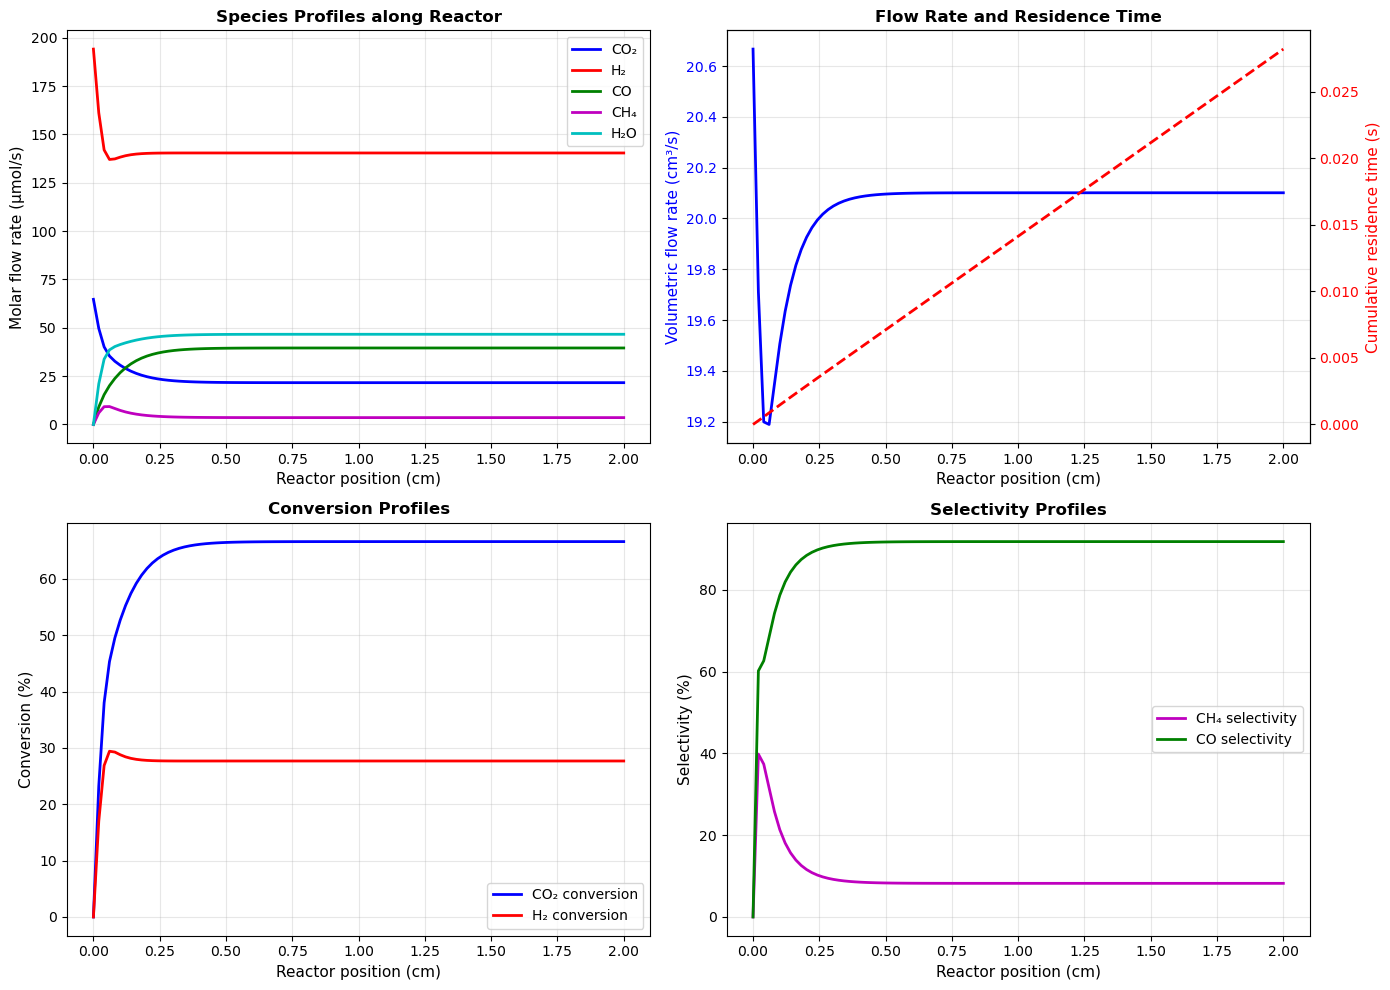

In [189]:
import matplotlib.pyplot as plt

# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Molar flow rate profiles
ax1 = axes[0, 0]
ax1.plot(z, F[0, :]*1e6, 'b-', label='CO₂', linewidth=2)
ax1.plot(z, F[1, :]*1e6, 'r-', label='H₂', linewidth=2)
ax1.plot(z, F[2, :]*1e6, 'g-', label='CO', linewidth=2)
ax1.plot(z, F[3, :]*1e6, 'm-', label='CH₄', linewidth=2)
ax1.plot(z, F[4, :]*1e6, 'c-', label='H₂O', linewidth=2)
ax1.set_xlabel('Reactor position (cm)', fontsize=11)
ax1.set_ylabel('Molar flow rate (μmol/s)', fontsize=11)
ax1.set_title('Species Profiles along Reactor', fontsize=12, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Plot 2: Volumetric flow rate and residence time
ax2 = axes[0, 1]
ax2_twin = ax2.twinx()
ax2.plot(z, Q_profile, 'b-', linewidth=2, label='Q(z)')
ax2_twin.plot(z, tau_cumulative, 'r--', linewidth=2, label='τ(z)')
ax2.set_xlabel('Reactor position (cm)', fontsize=11)
ax2.set_ylabel('Volumetric flow rate (cm³/s)', color='b', fontsize=11)
ax2_twin.set_ylabel('Cumulative residence time (s)', color='r', fontsize=11)
ax2.set_title('Flow Rate and Residence Time', fontsize=12, fontweight='bold')
ax2.tick_params(axis='y', labelcolor='b')
ax2_twin.tick_params(axis='y', labelcolor='r')
ax2.grid(True, alpha=0.3)

# Plot 3: Conversion profiles
ax3 = axes[1, 0]
X_CO2_profile = (F0[0] - F[0, :]) / F0[0] * 100
X_H2_profile = (F0[1] - F[1, :]) / F0[1] * 100
ax3.plot(z, X_CO2_profile, 'b-', linewidth=2, label='CO₂ conversion')
ax3.plot(z, X_H2_profile, 'r-', linewidth=2, label='H₂ conversion')
ax3.set_xlabel('Reactor position (cm)', fontsize=11)
ax3.set_ylabel('Conversion (%)', fontsize=11)
ax3.set_title('Conversion Profiles', fontsize=12, fontweight='bold')
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3)

# Plot 4: Selectivity profiles
ax4 = axes[1, 1]
CO2_conv_profile = F0[0] - F[0, :]
S_CH4_profile = np.where(CO2_conv_profile > 1e-12, F[3, :] / CO2_conv_profile * 100, 0)
S_CO_profile = np.where(CO2_conv_profile > 1e-12, F[2, :] / CO2_conv_profile * 100, 0)
ax4.plot(z, S_CH4_profile, 'm-', linewidth=2, label='CH₄ selectivity')
ax4.plot(z, S_CO_profile, 'g-', linewidth=2, label='CO selectivity')
ax4.set_xlabel('Reactor position (cm)', fontsize=11)
ax4.set_ylabel('Selectivity (%)', fontsize=11)
ax4.set_title('Selectivity Profiles', fontsize=12, fontweight='bold')
ax4.legend(fontsize=10)
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [190]:
# Data generation with noise in results
import pandas as pd

# Define parameter grid
GHSV_list = np.arange(100000, 200001, 20000)  # 100000, 120000, ..., 200000
T_list = [400, 500, 600, 700, 800]  # °C
P_fixed = 1.01325  # bar (fixed)

# Store results
results = []

print("Generating synthetic data with 5% noise in conversion/selectivity...")
print(f"GHSV values: {GHSV_list}")
print(f"Temperature values: {T_list}")

for T_test in T_list:
    for GHSV_test in GHSV_list:
        # Calculate inlet conditions
        Q0_test = GHSV_test * W_cat / 3600  # cm3/s
        TK_test = T_test + 273.15
        F0_total_test = Q0_test * P_fixed / (R * TK_test)
        
        F0_test = np.zeros(5)
        F0_test[0] = F0_total_test * zCO2
        F0_test[1] = F0_total_test * zH2
        F0_test[2] = 1e-10  # CO (avoid division by zero)
        F0_test[3] = 1e-10  # CH4 (avoid division by zero)
        F0_test[4] = 1e-10  # H2O (avoid division by zero)
        
        # Solve with original parameters (model prediction)
        sol_model = solve_ivp(
            fun=lambda z, F: pfr_model(z, F, T_test, k, P_fixed, A, rho_cat, m_content),
            t_span=(0, L),
            y0=F0_test,
            method='BDF',
            rtol=1e-8,
            atol=1e-10
        )
        
        if sol_model.success:
            # Extract outlet conditions (model prediction)
            F_out_model = sol_model.y[:, -1]
            
            # Calculate conversions and selectivities from model (true values)
            X_CO2_model = (F0_test[0] - F_out_model[0]) / F0_test[0] * 100
            CO2_conv_model = F0_test[0] - F_out_model[0]
            S_CH4_model = F_out_model[3] / CO2_conv_model * 100 if CO2_conv_model > 0 else 0
            S_CO_model = F_out_model[2] / CO2_conv_model * 100 if CO2_conv_model > 0 else 0
            
            # Add 5% noise to conversion and CO selectivity (experimental data)
            noise_conv = 1 + 0.05 * (2 * np.random.rand() - 1)  # ±5% noise for conversion
            noise_S_CO = 1 + 0.10 * (2 * np.random.rand() - 1)  # ±5% noise for CO selectivity
            
            X_CO2_data = X_CO2_model * noise_conv
            S_CO_data = S_CO_model * noise_S_CO
            
            # Ensure physical constraints
            X_CO2_data = np.clip(X_CO2_data, 0, 100)  # Conversion between 0-100%
            S_CO_data = np.clip(S_CO_data, 0, 100)    # CO selectivity between 0-100%
            
            # CH4 selectivity is the remainder to ensure S_CH4 + S_CO = 100%
            S_CH4_data = 100.0 - S_CO_data
            
            # Back-calculate outlet flow rates from noisy conversion/selectivity
            CO2_conv_data = F0_test[0] * X_CO2_data / 100
            F_CO2_data = F0_test[0] - CO2_conv_data
            F_CH4_data = CO2_conv_data * S_CH4_data / 100
            F_CO_data = CO2_conv_data * S_CO_data / 100
            
            # H2 and H2O from stoichiometry (approximate)
            # MTN: CO2 + 4H2 -> CH4 + 2H2O (CH4 from CO2)
            # RWGS: CO2 + H2 -> CO + H2O (CO from CO2)
            # OTN: CO + 3H2 -> CH4 + H2O (CH4 from CO, net CO consumption)
            CH4_from_CO2 = F_CH4_data - (F_out_model[2] - F_CO_data)  # Approximate
            CH4_from_CO2 = np.maximum(CH4_from_CO2, 0)
            
            H2_consumed_MTN = 4 * CH4_from_CO2
            H2_consumed_RWGS = F_CO_data
            H2_consumed_OTN = 3 * (F_CH4_data - CH4_from_CO2)
            F_H2_data = F0_test[1] - (H2_consumed_MTN + H2_consumed_RWGS + H2_consumed_OTN)
            
            H2O_from_MTN = 2 * CH4_from_CO2
            H2O_from_RWGS = F_CO_data
            H2O_from_OTN = F_CH4_data - CH4_from_CO2
            F_H2O_data = H2O_from_MTN + H2O_from_RWGS + H2O_from_OTN
            
            results.append({
                'T': T_test,
                'GHSV': GHSV_test,
                'X_CO2_data': X_CO2_data,
                'X_CO2_model': X_CO2_model,
                'S_CH4_data': S_CH4_data,
                'S_CH4_model': S_CH4_model,
                'S_CO_data': S_CO_data,
                'S_CO_model': S_CO_model,
                'F_CO2_data': F_CO2_data * 1e6,  # μmol/s
                'F_H2_data': F_H2_data * 1e6,
                'F_CO_data': F_CO_data * 1e6,
                'F_CH4_data': F_CH4_data * 1e6,
                'F_H2O_data': F_H2O_data * 1e6,
                'F_CO2_model': F_out_model[0] * 1e6,
                'F_H2_model': F_out_model[1] * 1e6,
                'F_CO_model': F_out_model[2] * 1e6,
                'F_CH4_model': F_out_model[3] * 1e6,
                'F_H2O_model': F_out_model[4] * 1e6
            })

df = pd.DataFrame(results)
print(f"\nGenerated {len(df)} data points successfully!")
print(df.head(10))

# Check selectivity sum
df['S_total_model'] = df['S_CH4_model'] + df['S_CO_model']
df['S_total_data'] = df['S_CH4_data'] + df['S_CO_data']
print(f"\n=== Selectivity Sum Check ===")
print(f"Model S_total range: {df['S_total_model'].min():.2f}% - {df['S_total_model'].max():.2f}%")
print(f"Data S_total range: {df['S_total_data'].min():.2f}% - {df['S_total_data'].max():.2f}%")
print(f"All data sums are 100%: {(df['S_total_data'] == 100.0).all()}")

Generating synthetic data with 5% noise in conversion/selectivity...
GHSV values: [100000 120000 140000 160000 180000 200000]
Temperature values: [400, 500, 600, 700, 800]

Generated 30 data points successfully!
     T    GHSV  X_CO2_data  X_CO2_model  S_CH4_data  S_CH4_model  S_CO_data  \
0  400  100000   24.091255    24.248869   82.305268    81.885275  17.694732   
1  400  120000   21.565579    21.145711   81.562600    81.415784  18.437400   
2  400  140000   19.183838    18.746591   80.467252    81.065923  19.532748   
3  400  160000   17.492653    16.836708   81.687511    80.793579  18.312489   
4  400  180000   14.924641    15.280473   80.913503    80.574520  19.086497   
5  400  200000   13.959135    13.987906   79.119878    80.394198  20.880122   
6  500  100000   58.977318    59.116520   82.456021    81.955596  17.543979   
7  500  120000   57.877986    58.610525   77.944798    79.352801  22.055202   
8  500  140000   60.049774    57.524851   77.491779    77.057028  22.508221  

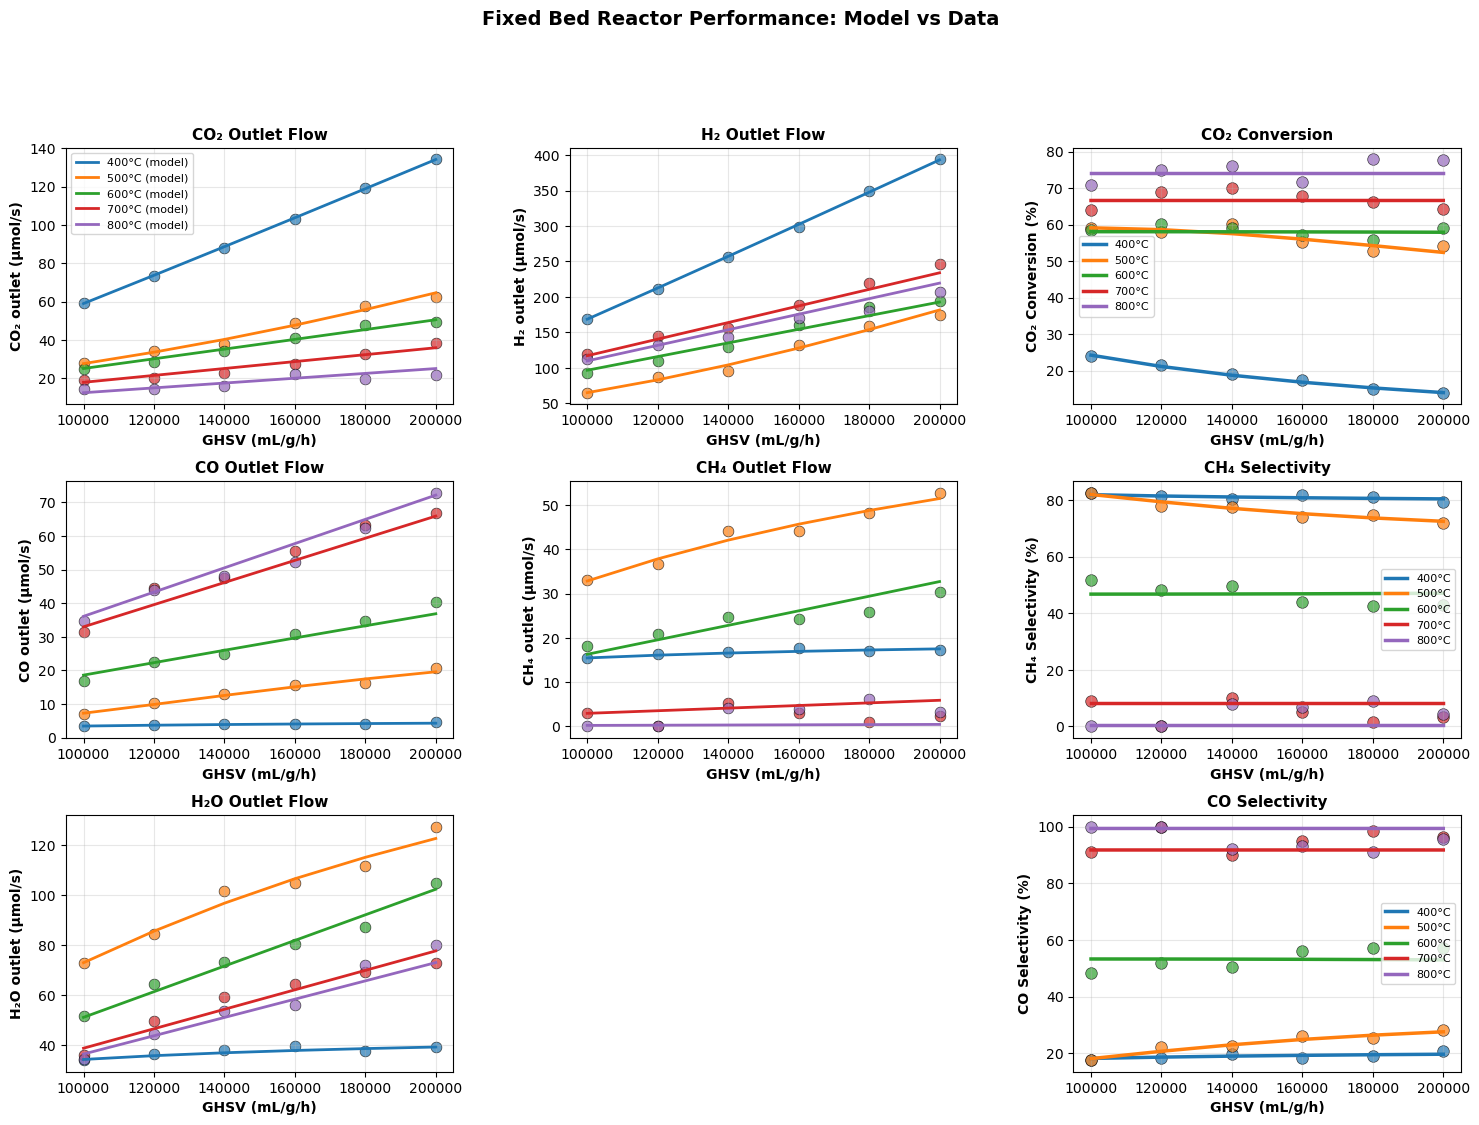


Legend: Lines = Model predictions, Points = Generated data (±10% noise)


In [191]:
# Visualization: Model vs Data comparison - Species flow rates and performance
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
species_names = ['CO₂', 'H₂', 'CO', 'CH₄', 'H₂O']
species_cols = ['CO2', 'H2', 'CO', 'CH4', 'H2O']

# Plot each species outlet flow rate (2x3 grid on left)
for idx, (species, name) in enumerate(zip(species_cols, species_names)):
    row = idx // 2
    col = idx % 2
    ax = fig.add_subplot(gs[row, col])
    
    for i, T_val in enumerate(T_list):
        df_T = df[df['T'] == T_val]
        ax.plot(df_T['GHSV'], df_T[f'F_{species}_model'], '-', 
               color=colors[i], linewidth=2, label=f'{T_val}°C (model)')
        ax.scatter(df_T['GHSV'], df_T[f'F_{species}_data'], marker='o', 
                  s=60, color=colors[i], alpha=0.7, edgecolors='black', linewidth=0.5)
    
    ax.set_xlabel('GHSV (mL/g/h)', fontsize=10, fontweight='bold')
    ax.set_ylabel(f'{name} outlet (μmol/s)', fontsize=10, fontweight='bold')
    ax.set_title(f'{name} Outlet Flow', fontsize=11, fontweight='bold')
    if idx == 0:  # Add legend only to first plot
        ax.legend(fontsize=8, loc='best')
    ax.grid(True, alpha=0.3)

# Right column: Performance metrics (3x1 grid)

# Plot 1: CO2 Conversion
ax1 = fig.add_subplot(gs[0, 2])
for i, T_val in enumerate(T_list):
    df_T = df[df['T'] == T_val]
    ax1.plot(df_T['GHSV'], df_T['X_CO2_model'], '-', color=colors[i], 
             linewidth=2.5, label=f'{T_val}°C')
    ax1.scatter(df_T['GHSV'], df_T['X_CO2_data'], marker='o', s=70, 
                color=colors[i], alpha=0.7, edgecolors='black', linewidth=0.5)
ax1.set_xlabel('GHSV (mL/g/h)', fontsize=10, fontweight='bold')
ax1.set_ylabel('CO₂ Conversion (%)', fontsize=10, fontweight='bold')
ax1.set_title('CO₂ Conversion', fontsize=11, fontweight='bold')
ax1.legend(fontsize=8, loc='best')
ax1.grid(True, alpha=0.3)

# Plot 2: CH4 Selectivity
ax2 = fig.add_subplot(gs[1, 2])
for i, T_val in enumerate(T_list):
    df_T = df[df['T'] == T_val]
    ax2.plot(df_T['GHSV'], df_T['S_CH4_model'], '-', color=colors[i], 
             linewidth=2.5, label=f'{T_val}°C')
    ax2.scatter(df_T['GHSV'], df_T['S_CH4_data'], marker='o', s=70, 
                color=colors[i], alpha=0.7, edgecolors='black', linewidth=0.5)
ax2.set_xlabel('GHSV (mL/g/h)', fontsize=10, fontweight='bold')
ax2.set_ylabel('CH₄ Selectivity (%)', fontsize=10, fontweight='bold')
ax2.set_title('CH₄ Selectivity', fontsize=11, fontweight='bold')
ax2.legend(fontsize=8, loc='best')
ax2.grid(True, alpha=0.3)

# Plot 3: CO Selectivity
ax3 = fig.add_subplot(gs[2, 2])
for i, T_val in enumerate(T_list):
    df_T = df[df['T'] == T_val]
    ax3.plot(df_T['GHSV'], df_T['S_CO_model'], '-', color=colors[i], 
             linewidth=2.5, label=f'{T_val}°C')
    ax3.scatter(df_T['GHSV'], df_T['S_CO_data'], marker='o', s=70, 
                color=colors[i], alpha=0.7, edgecolors='black', linewidth=0.5)
ax3.set_xlabel('GHSV (mL/g/h)', fontsize=10, fontweight='bold')
ax3.set_ylabel('CO Selectivity (%)', fontsize=10, fontweight='bold')
ax3.set_title('CO Selectivity', fontsize=11, fontweight='bold')
ax3.legend(fontsize=8, loc='best')
ax3.grid(True, alpha=0.3)

plt.suptitle('Fixed Bed Reactor Performance: Model vs Data', 
             fontsize=14, fontweight='bold', y=0.995)
plt.show()

print("\n" + "="*70)
print("Legend: Lines = Model predictions, Points = Generated data (±10% noise)")
print("="*70)

In [192]:
# Statistical analysis of model vs data
print("="*60)
print("STATISTICAL ANALYSIS: Model vs Data")
print("="*60)

# Calculate residuals and statistics
df['residual_X_CO2'] = df['X_CO2_data'] - df['X_CO2_model']
df['residual_S_CH4'] = df['S_CH4_data'] - df['S_CH4_model']

# Overall statistics
print("\n[CO2 Conversion]")
print(f"  Mean absolute error: {np.abs(df['residual_X_CO2']).mean():.4f}%")
print(f"  Root mean square error: {np.sqrt((df['residual_X_CO2']**2).mean()):.4f}%")
print(f"  Max deviation: {np.abs(df['residual_X_CO2']).max():.4f}%")

print("\n[CH4 Selectivity]")
print(f"  Mean absolute error: {np.abs(df['residual_S_CH4']).mean():.4f}%")
print(f"  Root mean square error: {np.sqrt((df['residual_S_CH4']**2).mean()):.4f}%")
print(f"  Max deviation: {np.abs(df['residual_S_CH4']).max():.4f}%")

# Statistics by temperature
print("\n" + "="*60)
print("STATISTICS BY TEMPERATURE")
print("="*60)

for T_val in T_list:
    df_T = df[df['T'] == T_val]
    print(f"\nT = {T_val}°C:")
    print(f"  CO2 conversion MAE: {np.abs(df_T['residual_X_CO2']).mean():.4f}%")
    print(f"  CH4 selectivity MAE: {np.abs(df_T['residual_S_CH4']).mean():.4f}%")

# Save data to CSV
csv_filename = 'co2_hydrogenation_data.csv'
df.to_csv(csv_filename, index=False)
print(f"\n{'='*60}")
print(f"Data saved to: {csv_filename}")
print(f"Total data points: {len(df)}")
print(f"{'='*60}")

STATISTICAL ANALYSIS: Model vs Data

[CO2 Conversion]
  Mean absolute error: 1.5085%
  Root mean square error: 1.8723%
  Max deviation: 3.6041%

[CH4 Selectivity]
  Mean absolute error: 2.7056%
  Root mean square error: 3.6938%
  Max deviation: 8.3729%

STATISTICS BY TEMPERATURE

T = 400°C:
  CO2 conversion MAE: 0.3425%
  CH4 selectivity MAE: 0.6121%

T = 500°C:
  CO2 conversion MAE: 1.2383%
  CH4 selectivity MAE: 0.8765%

T = 600°C:
  CO2 conversion MAE: 1.3093%
  CH4 selectivity MAE: 3.4190%

T = 700°C:
  CO2 conversion MAE: 2.0385%
  CH4 selectivity MAE: 4.1657%

T = 800°C:
  CO2 conversion MAE: 2.6141%
  CH4 selectivity MAE: 4.4544%

Data saved to: co2_hydrogenation_data.csv
Total data points: 30
